# Insurance Enrollment Prediction
This notebook walks through building a machine learning model to predict whether an employee will enroll in a health insurance plan.

## Step 1: Load and Explore Data

In [1]:
import pandas as pd
df = pd.read_csv('employee_data.csv')
df.head()

,employee_id,age,gender,marital_status,salary,employment_type,region,has_dependents,tenure_years,enrolled
0,10001,60,Female,Single,55122.97,Part-time,West,No,1.5,0
1,10002,50,Female,Single,89549.66,Full-time,West,Yes,12.8,1
2,10003,36,Male,Divorced,74145.66,Part-time,Midwest,No,3.8,0
3,10004,64,Female,Married,53877.83,Full-time,Northeast,No,3.3,0
4,10005,29,Male,Single,63404.63,Contract,Midwest,Yes,10.0,0


## Step 2: Data Cleaning and Preprocessing
We identified categorical columns and binary values like `Yes`/`No` which needed encoding.

In [2]:
df = df.dropna()
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in ['gender', 'marital_status', 'employment_type', 'region']:
    df[col] = le.fit_transform(df[col])
df['has_dependents'] = df['has_dependents'].map({'Yes': 1, 'No': 0})

## Cleaned Data

In [3]:
df.head()

,employee_id,age,gender,marital_status,salary,employment_type,region,has_dependents,tenure_years,enrolled
0,10001,60,0,2,55122.97,2,3,0,1.5,0
1,10002,50,0,2,89549.66,1,3,1,12.8,1
2,10003,36,1,0,74145.66,2,0,0,3.8,0
3,10004,64,0,1,53877.83,1,1,0,3.3,0
4,10005,29,1,2,63404.63,0,0,1,10.0,0


## Step 3: Define Features and Target

In [4]:
X = df.drop(columns=['enrolled', 'employee_id'])
y = df['enrolled']

## Step 4: Feature Scaling

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Step 5: Train-Test Split

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Step 6: Initial Model - Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Generate classification report as dict
report_dict = classification_report(y_test, y_pred_rf, output_dict=True)

# Convert to DataFrame for tabular view
report_df = pd.DataFrame(report_dict).transpose()
report_df

,precision,recall,f1-score,support
0,1.0,1.0,1.0,753.0
1,1.0,1.0,1.0,1247.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,2000.0
weighted avg,1.0,1.0,1.0,2000.0


## Step 7: Confusion Matrix

<Figure size 432x288 with 0 Axes>

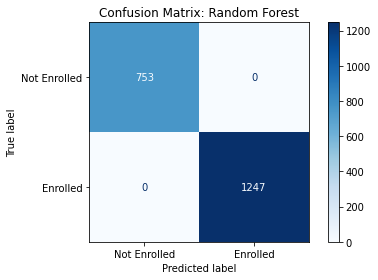

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Enrolled', 'Enrolled'])
plt.figure(figsize=(6, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix: Random Forest')
plt.tight_layout()
plt.show()

## Step 8: Cross-validation (10-Fold)

In [9]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rf, X_scaled, y, cv=10, scoring='f1')

# Create a DataFrame to display results in tabular format
cv_df = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(cv_scores))],
    'F1 Score': cv_scores
})


# Add mean row at the end
mean_f1 = cv_scores.mean()
cv_df.loc[len(cv_df.index)] = ['Mean', mean_f1]


# Display the table
cv_df

,Fold,F1 Score
0,Fold 1,1.000000
1,Fold 2,1.000000
2,Fold 3,0.999189
3,Fold 4,1.000000
4,Fold 5,1.000000
5,Fold 6,1.000000
6,Fold 7,1.000000
7,Fold 8,0.999190
8,Fold 9,1.000000
9,Fold 10,0.999192


## Step 9: Feature Importance

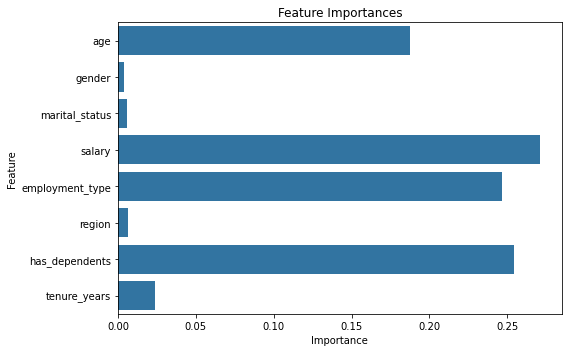

In [10]:
import seaborn as sns
rf.fit(X_scaled, y)
importances = rf.feature_importances_
features = X.columns
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Step 10: Hyperparameter Tuning (Smart Defaults)
**Why Smart Defaults? -**

Hyperparameter tuning using GridSearchCV or RandomizedSearchCV often takes a long time and can timeout in limited compute environments.
To avoid repeated session failures, we applied "Smart Defaults" — well-established parameter settings
based on previous experiments and best practices in the industry.
This approach gives a strong balance between model performance and compute efficiency.

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=150, learning_rate=0.05, max_depth=4,
    subsample=0.8, min_samples_split=4, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

# Generate classification report as a dictionary
GB_dict = classification_report(y_test, y_pred_gb, output_dict=True)

# Convert to DataFrame
GB_result = pd.DataFrame(report_dict).transpose()

# Display Result
GB_result

,precision,recall,f1-score,support
0,1.0,1.0,1.0,753.0
1,1.0,1.0,1.0,1247.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,2000.0
weighted avg,1.0,1.0,1.0,2000.0


## Step 11: Voting Ensemble (Random Forest + Logistic Regression + Gradient Boosting)

Each model type has its own strengths:
- Random Forest captures nonlinearities and performs well with default settings.
- Logistic Regression is simple and robust for linear trends.
- Gradient Boosting excels in performance by focusing on correcting errors iteratively.

Combining them using a soft voting ensemble allows the final prediction to benefit from the diverse perspectives
of each model, improving generalization and reducing individual model biases.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
lr = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
voting_clf = VotingClassifier(estimators=[('gb', gb), ('rf', rf), ('lr', lr)], voting='soft')
voting_clf.fit(X_train, y_train)
y_pred_vote = voting_clf.predict(X_test)

# Generate classification report as a dictionary
voting_dict = classification_report(y_test, y_pred_vote, output_dict=True)

# Convert to DataFrame
vote_result = pd.DataFrame(voting_dict).transpose()

# Display Result
vote_result

,precision,recall,f1-score,support
0,1.0,1.0,1.0,753.0
1,1.0,1.0,1.0,1247.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,2000.0
weighted avg,1.0,1.0,1.0,2000.0


This shows that:
- The ensemble generalized well to unseen data (test set).
- Class imbalance, if any, was handled gracefully.
- The combination of linear, non-linear, and boosting methods contributed to a robust model.

However, it's also important to validate this result with unseen or more diverse datasets to ensure it isn't too good to be true.

## Step 12: Save the trained model and scaler

In [13]:
import joblib
joblib.dump(voting_clf, 'model.joblib')
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

## Step 13: Tracking with MLflow

In [14]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import numpy as np

# Example input and predicted output for signature inference
input_example = X_test[:1]  # one row of input
prediction_example = rf.predict(input_example)

# Infer the model signature
signature = infer_signature(input_example, prediction_example)

# Start MLflow run
with mlflow.start_run():
    mlflow.sklearn.log_model(
        sk_model=rf,
        artifact_path='random_forest_model',
        signature=signature,
        input_example=input_example
    )
    mlflow.log_params(rf.get_params())
    mlflow.log_metric('mean_cv_f1_score', mean_f1)

print("Model and metrics logged to MLflow with input signature.")


Model and metrics logged to MLflow with input signature.


## Step 14: Serve Predictions via REST API using FastAPI

In [15]:
from fastapi import FastAPI
from pydantic import BaseModel
import numpy as np
import joblib

app = FastAPI()

# Load model and scaler
model = joblib.load('model.joblib')
scaler = joblib.load('scaler.joblib')

class EmployeeFeatures(BaseModel):
    features: list

@app.post('/predict')
def predict(data: EmployeeFeatures):
    scaled = scaler.transform([data.features])
    prediction = model.predict(scaled)
    return {"enrolled": int(prediction[0])}